<a href="https://colab.research.google.com/github/prysykes/trevec/blob/main/NSTtrevec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install opencv-python
!pip install opencv-python-headless
!pip install matplotlib
!pip install tf-models-official
!pip install tqdm
!pip install nltk
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 36.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 26.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=fcf6449214f3bb434a253de721a82e0a2441f67094a29dcf6f180e9943ede4fb
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [1]:
import tensorflow as tf
# import tqdm
import random
import pathlib
import itertools
import collections

import os
import glob
import cv2
import numpy as np
# import remotezip as rz

import tensorflow as tf
import tensorflow_hub as hub
import nltk
nltk.download('wordnet')
#modules to display animation using imageio
# import imageio
# from IPython import display
# from urllib import request
# from tensorflow_docs.vis import embed

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [2]:
trevec_vids = '/content/trevec_videos'
print(os.path.isdir(trevec_vids))

True


In [ ]:
# pathh = trevec_vids

# for parent, dirs, files in os.walk(pathh, topdown=False):
#   for file in files:
#     file_path = os.path.join(parent, file)
#     os.remove(file_path)
#   for dir in dirs:
#     dir_path = os.path.join(parent, dir)
#     os.rmdir(dir_path)


In [3]:
import sys
print(sys.version)
print(tf.__version__)

3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
2.14.0


In [4]:
def format_frame_size(frame, output_size):
    """
        Function to Pad and resize a frame from a video
        Args:
            Frame: An image that needs resizing or padding
            output_size: A tupple of width and height Required pixel size of the padded image
        Return:
            A frame formatted according to the output size
    """
    frame = tf.image.convert_image_dtype(frame, tf.float32)
    frame = tf.image.resize_with_pad(frame, *output_size)
    return frame

In [5]:
def frames_from_video_file(video_path, n_frames, output_size=(224, 224), frame_step=10):
    """
        Creates frames from a video file
        Args:
            video_path: path to the video file
            n_frames: Number of frames to be created per video
            output_size = size of the output_frame
        return:
            An NumPy array of frames in the shape (n_frames, height, width, channels)
    """
    results = []
    src = cv2.VideoCapture(str(video_path))
    file_name = video_path.split('/')[-1]
    video_length = src.get(cv2.CAP_PROP_FRAME_COUNT) # total frames in video
    # print("video_length", video_length)
    need_length = 1 + (n_frames - 1) * frame_step
    # print("need_length", need_length)

    if need_length > video_length:
        #if the total frames in the vid is
        #shorter than the needed lenght
        #no need for the offset, start reading at 0
        start = 0
    else:
        max_start = video_length - need_length
        start = random.randint(0, max_start +1)
    src.set(cv2.CAP_PROP_POS_FRAMES, start)
    ret, frame = src.read()
    #read first frame before skipping by frame_step
    results.append(format_frame_size(frame, output_size))

    #n_frames-1 bc we read the 1st frame already
    for _ in range(n_frames - 1):
        # this loop returns the last frame referenced by the frame step
        # in effect, it it reads frames that are frame_step apart
        for _ in range(frame_step):
            ret, frame = src.read()
        if ret:
            frame = format_frame_size(frame, output_size)
            results.append(frame)
        else:
            #saves a numpy array of all zeros of shape frame.shape
            frame = np.zeros_like(results[0])
            results.append(frame)

    src.release()
    results = np.array(results)[..., [2, 1, 0]]
    return results





In [9]:
video_paths = glob.glob(f"{trevec_vids}/*")
# x = video_paths[0]
# num_part = int(x.split('/')[-1].split('.')[0])
# print(num_part)
print(type(video_paths))
#sort video according to file number
#sort video according to the file name
video_paths = sorted(video_paths, key=lambda x: int(x.split('/')[-1].split('.')[0]))


<class 'list'>


In [10]:
n = 0
for file in video_paths:
    if n > 2:
        break
    print(file)
    n +=1

/content/trevec_videos/1.webm
/content/trevec_videos/2.webm
/content/trevec_videos/3.webm


In [11]:
trevec_sample_vid = frames_from_video_file(video_paths[0], 20)

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

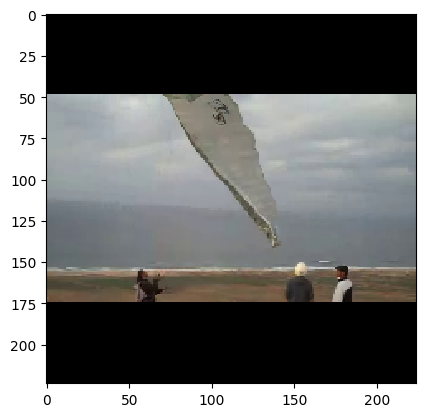

In [13]:
plt.imshow(trevec_sample_vid[0], interpolation='nearest')
plt.show()

In [14]:
plt.show()

In [15]:
class FrameGenerator:
    def __init__(self, video_paths, n_frames, training=False):
        """
            Returns a set of frames from a video in the video_paths list

            Args:
            video_paths: a list of path to videos
            n_frames: Number of frames
            training: A boolean to determine if a training dataset should be created
        """

        self.video_paths = video_paths
        self.n_frames = n_frames
        self.training = training

    def __call__(self):
        """
            gets called and yields a set of frames
            each the the instance of the class is called
        """
        video_paths = self.video_paths
        # print(type(video_paths))
        if self.training:
            random.shuffle(video_paths)

        for path in video_paths:
            video_frames = frames_from_video_file(path, self.n_frames)
            file_name = path.split('/')[-1]
            # print(file_name, "filfile")
            yield video_frames, file_name

In [16]:
fg = FrameGenerator(video_paths, 20, training=False)



In [17]:
frames = next(iter(fg()))

In [18]:
frames[0].shape
print(frames[1])

1.webm


In [19]:
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype=tf.float32), tf.TensorSpec(shape = None, dtype=tf.string))

dataset = tf.data.Dataset.from_generator(FrameGenerator(video_paths, 20, training=False), output_signature=output_signature)

In [20]:
BATCH_SIZE =2

In [21]:
inference_datasets = dataset.batch(BATCH_SIZE)

In [22]:
sample_inference_dataset = next(iter(inference_datasets))
#return a tupple containing a numpy array of frames belonging to each video with size of BATCH_SIZE
# and a list of their corresponding file name



In [23]:
print("len(sample_inference_dataset)", len(sample_inference_dataset))
print("sample_inference_dataset[0].shape", sample_inference_dataset[0].shape)
print("sample_inference_dataset[1]", (sample_inference_dataset[1]))
print("sample_inference_dataset[0][0] shape", (sample_inference_dataset[0][0].shape))
# tf_string = tf.constant(sample_inference_dataset[1][0])
string_value = sample_inference_dataset[1][0].numpy().decode('utf-8')
print("sample_inference_dataset[1][0]", string_value)

len(sample_inference_dataset) 2
sample_inference_dataset[0].shape (2, 20, 224, 224, 3)
sample_inference_dataset[1] tf.Tensor([b'1.webm' b'2.webm'], shape=(2,), dtype=string)
sample_inference_dataset[0][0] shape (20, 224, 224, 3)
sample_inference_dataset[1][0] 1.webm


In [24]:
for idx in range(len(sample_inference_dataset[0])):
  print(idx)

0
1


In [ ]:
# for idx in range(BATCH_SIZE):
#   cur_tupple = next(iter(inference_datasets))
#   cur_inference_dataset = cur_tupple[0]
#   file_name = cur_tupple[1][idx]
#   print("cur_tupple[1]", cur_tupple[1])
#   print("file_name", file_name)


In [ ]:
# inference_dataset.shape

In [25]:
id = 'a2'
mode = 'base'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

In [26]:
labels_path = tf.keras.utils.get_file(
    fname='labels.txt',
    origin='https://raw.githubusercontent.com/tensorflow/models/f8af2291cced43fc9f1d9b41ddbf772ae7b0d7d2/official/projects/movinet/files/kinetics_600_labels.txt'
)
labels_path = pathlib.Path(labels_path)

lines = labels_path.read_text().splitlines()
KINETICS_600_LABELS = np.array([line.strip() for line in lines])
KINETICS_600_LABELS[:20]

9209/9209 [==============================] - 0s 0us/step


array(['abseiling', 'acting in play', 'adjusting glasses', 'air drumming',
       'alligator wrestling', 'answering questions', 'applauding',
       'applying cream', 'archaeological excavation', 'archery',
       'arguing', 'arm wrestling', 'arranging flowers',
       'assembling bicycle', 'assembling computer',
       'attending conference', 'auctioning', 'backflip (human)',
       'baking cookies', 'bandaging'], dtype='<U49')

In [ ]:
# print(KINETICS_600_LABELS)

In [27]:
sig = model.signatures['serving_default']
print(sig.pretty_printed_signature())

signature_wrapper(*, image)
  Args:
    image: float32 Tensor, shape=(None, None, None, None, 3)
  Returns:
    {'classifier_head': <1>}
      <1>: float32 Tensor, shape=(None, 600)


In [28]:
sig(image = sample_inference_dataset[0])

{'classifier_head': <tf.Tensor: shape=(2, 600), dtype=float32, numpy=
 array([[-0.50507224,  0.19461715,  0.66370386, ...,  0.25059167,
          2.361664  ,  0.3417308 ],
        [-2.2712166 , -0.424963  ,  0.05532325, ...,  1.2339801 ,
         -1.7564478 ,  0.8318926 ]], dtype=float32)>}

In [29]:
print(sample_inference_dataset[0].shape)

(2, 20, 224, 224, 3)


In [30]:
%%time
logits = sig(image=sample_inference_dataset[0])
logits = logits['classifier_head'][0]
print(logits.shape)
print()

(600,)

CPU times: user 1min 57s, sys: 756 ms, total: 1min 58s
Wall time: 1min 19s


In [31]:
#@title
# Get top_k labels and probabilities
def get_top_k(probs, k=5, label_map=KINETICS_600_LABELS, capture_output=False):
  """Outputs the top k model labels and probabilities on the given video.

  Args:
    probs: probability tensor of shape (num_frames, num_classes) that represents
      the probability of each class on each frame.
    k: the number of top predictions to select.
    label_map: a list of labels to map logit indices to label strings.

  Returns:
    a tuple of the top-k labels and probabilities.
  """
  # Sort predictions to find top_k
  top_predictions = tf.argsort(probs, axis=-1, direction='DESCENDING')[:k]
  # collect the labels of top_k predictions
  top_labels = tf.gather(label_map, top_predictions, axis=-1)
  # decode lablels
  top_labels = [label.decode('utf8') for label in top_labels.numpy()]
  # top_k probabilities of the predictions
  top_probs = tf.gather(probs, top_predictions, axis=-1).numpy()
  # if capture_output == True:
  #   yield tuple(zip(top_labels, top_probs))

  # else:
  yield tuple(zip(top_labels, top_probs))


In [32]:
for idx in range(len(sample_inference_dataset[0])):
  if idx > 2:
    break
  file_name = sample_inference_dataset[1][idx]
  cur_inference_dataset = sample_inference_dataset[0][idx]
  cur_inference_dataset = cur_inference_dataset[tf.newaxis, ...]
  logits = sig(image=cur_inference_dataset)
  logits = logits['classifier_head'][0]
  probs = tf.nn.softmax(logits, axis=-1)
  top_k_labels = get_top_k(probs)
  print(top_k_labels)
  # file_name = cur_tupple[1][idx]
  # print("cur_tupple[1]", cur_tupple[1])
  print("file_name", file_name)

<generator object get_top_k at 0x7ecfe467fe60>
file_name tf.Tensor(b'1.webm', shape=(), dtype=string)
<generator object get_top_k at 0x7ecfe785c900>
file_name tf.Tensor(b'2.webm', shape=(), dtype=string)


In [33]:
probs = tf.nn.softmax(logits, axis=-1)
top_k_labels = list(get_top_k(probs))
print(top_k_labels)
close_labels = {}
for idx, lab_conf in enumerate(top_k_labels):
  # print(lab_conf[1]-1)
  if idx == 0:
    close_labels[f'{lab_conf[0]}'] = lab_conf[1]
  else:
    close_labels_keys = list(close_labels.keys())
    best_class = close_labels_keys[0]
    # print(type(float(close_labels[best_class])), type(float(lab_conf[1])))
    print(close_labels[best_class]-lab_conf[1])
    # if close_labels[best_class] - lab_conf[1] > 0.4:
    #   print('yes')
  # print(best_class)

print(close_labels)
# for label, p in get_top_k(probs):

#   print(f'{label:20s}: {p:.3f}')

[(('shuffling feet', 0.7110261), ('jumpstyle dancing', 0.22299384), ('jogging', 0.013496712), ('breakdancing', 0.0029309513), ('walking through snow', 0.0026067437))]
{"('shuffling feet', 0.7110261)": ('jumpstyle dancing', 0.22299384)}


#Stream version of the model

In [35]:
%%time
id = 'a2'
mode = 'stream'
version = '3'
hub_url = f'https://tfhub.dev/tensorflow/movinet/{id}/{mode}/kinetics-600/classification/{version}'
model = hub.load(hub_url)

CPU times: user 55.9 s, sys: 2.51 s, total: 58.4 s
Wall time: 58.6 s


In [36]:
list(model.signatures.keys())

['call', 'init_states']

In [37]:
lines = model.signatures['init_states'].pretty_printed_signature().splitlines()
lines = lines[:10]
lines.append('      ...')
print('.\n'.join(lines))

signature_wrapper(*, input_shape).
  Args:.
    input_shape: int32 Tensor, shape=(5,).
  Returns:.
    {'state/b0/l0/pool_buffer': <1>, 'state/b0/l0/pool_frame_count': <2>, 'state/b0/l1/pool_buffer': <3>, 'state/b0/l1/pool_frame_count': <4>, 'state/b0/l1/stream_buffer': <5>, 'state/b0/l2/pool_buffer': <6>, 'state/b0/l2/pool_frame_count': <7>, 'state/b0/l2/stream_buffer': <8>, 'state/b1/l0/pool_buffer': <9>, 'state/b1/l0/pool_frame_count': <10>, 'state/b1/l0/stream_buffer': <11>, 'state/b1/l1/pool_buffer': <12>, 'state/b1/l1/pool_frame_count': <13>, 'state/b1/l1/stream_buffer': <14>, 'state/b1/l2/pool_buffer': <15>, 'state/b1/l2/pool_frame_count': <16>, 'state/b1/l2/stream_buffer': <17>, 'state/b1/l3/pool_buffer': <18>, 'state/b1/l3/pool_frame_count': <19>, 'state/b1/l3/stream_buffer': <20>, 'state/b1/l4/pool_buffer': <21>, 'state/b1/l4/pool_frame_count': <22>, 'state/b1/l4/stream_buffer': <23>, 'state/b2/l0/pool_buffer': <24>, 'state/b2/l0/pool_frame_count': <25>, 'state/b2/l0/stream_b

In [38]:
print(sample_inference_dataset[0].shape)
initial_state_tensor = sample_inference_dataset[0][0][tf.newaxis, ...] # takes a video file (20,224, 224, 3) and adds a new axis eg (1, 20, 224, 224, 3)
print(initial_state_tensor.shape)

(2, 20, 224, 224, 3)
(1, 20, 224, 224, 3)


In [39]:
initial_state = model.init_states(initial_state_tensor.shape)

In [40]:
type(initial_state)

dict

In [41]:
list(sorted(initial_state.keys()))[:5]

['state/b0/l0/pool_buffer',
 'state/b0/l0/pool_frame_count',
 'state/b0/l1/pool_buffer',
 'state/b0/l1/pool_frame_count',
 'state/b0/l1/stream_buffer']

In [42]:
print(sample_inference_dataset[0][0].shape)

(20, 224, 224, 3)


In [43]:
inputs = initial_state.copy()
inputs['image'] = initial_state_tensor[0:1, ...]

In [44]:
# warmup
model(inputs);

In [45]:
initial_state = model.init_states(initial_state_tensor.shape)
state = initial_state.copy()
all_logits =[]
# warmup
# model(inputs)
for idx in range(len(sample_inference_dataset[0])):
  if idx > 2:
    break
  cur_input_tensor = sample_inference_dataset[0][idx]
  cur_input_tensor = cur_input_tensor[tf.newaxis]
  print(cur_input_tensor.shape)

  file_name = sample_inference_dataset[1][idx]

  inputs['image'] = cur_input_tensor[0:1, ...]
  #add a new axis, select first from from the array of frames, then selet the whole height, width and channel axis
  logits, new_state = model(inputs)
  logits = logits[0]
  probs = tf.nn.softmax(logits, axis=-1)
  initial_state = model.init_states(initial_state_tensor.shape)
  state = initial_state.copy()
  top_k_labels = tuple(get_top_k(probs, capture_output=True))
  print(len(top_k_labels[0]))
  print(top_k_labels)
  string_value = file_name.numpy().decode('utf-8')
  all_logits.append((logits, string_value))

  print("file_name", string_value)

(1, 20, 224, 224, 3)
5
((('paragliding', 0.4702189), ('flying kite', 0.1561818), ('parasailing', 0.1231873), ('kitesurfing', 0.04914223), ('skydiving', 0.033650793)),)
file_name 1.webm
(1, 20, 224, 224, 3)
5
((('shuffling feet', 0.40066084), ('jogging', 0.16968915), ('jumpstyle dancing', 0.13156785), ('delivering mail', 0.014214353), ('tap dancing', 0.010723671)),)
file_name 2.webm


In [47]:
initial_state = model.init_states(initial_state_tensor.shape)
state = initial_state.copy()
for idx, logits_filename in enumerate(all_logits):
  cur_input_tensor_rnn = sample_inference_dataset[0][idx]

  for n in range(len(sample_inference_dataset[0][idx])):
      inputs = state


      inputs['image'] = cur_input_tensor_rnn[tf.newaxis,n:n+1, ...]
      result, state = model(inputs)

  probabilities = tf.nn.softmax(logits_filename[0], axis=-1)
  top_k_labels = tuple(get_top_k(probabilities))
  # string_value = file_name.numpy().decode('utf-8')
  print(top_k_labels, logits_filename[1])


((('paragliding', 0.4702189), ('flying kite', 0.1561818), ('parasailing', 0.1231873), ('kitesurfing', 0.04914223), ('skydiving', 0.033650793)),) 1.webm
((('shuffling feet', 0.40066084), ('jogging', 0.16968915), ('jumpstyle dancing', 0.13156785), ('delivering mail', 0.014214353), ('tap dancing', 0.010723671)),) 2.webm


In [49]:
for class_conf in top_k_labels:
  print(class_conf)

(('shuffling feet', 0.40066084), ('jogging', 0.16968915), ('jumpstyle dancing', 0.13156785), ('delivering mail', 0.014214353), ('tap dancing', 0.010723671))


In [ ]:
# print(top_k_labels)
close_labels = {}
for idx, lab_conf in enumerate(top_k_labels[0]):
  if idx == 0:
    close_labels.setdefault(lab_conf[0].replace(' ', '_'), lab_conf[1])
  else:
    best_class = list(close_labels.keys())[0]
    best_class_conf = close_labels[best_class]
    cur_class = lab_conf[0].replace(' ', '_')
    cur_class_conf = lab_conf[1]
    best_class =
    if (best_class_conf - cur_class_conf) < 0.2:
      close_labels.setdefault(cur_class, cur_class_conf)


    print(f"best_class: {best_class} \t best_class_conf {best_class_conf} \t cur_class {cur_class} \t cur_class_conf {cur_class_conf}")



print(close_labels)

best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class jogging 	 cur_class_conf 0.2396440953016281
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class jumpstyle_dancing 	 cur_class_conf 0.11431951820850372
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class delivering_mail 	 cur_class_conf 0.02315945364534855
best_class: shuffling_feet 	 best_class_conf 0.2532516419887543 	 cur_class hopscotch 	 cur_class_conf 0.01479418482631445
{'shuffling_feet': 0.25325164, 'jogging': 0.2396441, 'jumpstyle_dancing': 0.11431952}


Generate Embeddings for the senstences and calculate the distancd between the embeddings

In [59]:
!git push -u origin main

error: src refspec main does not match any
error: failed to push some refs to 'https://github.com/prysykes/trevec.git'


In [ ]:
def check_close_scores(top_k_labels):
  close_labels = {}
  for idx, lab_conf in enumerate(top_k_labels[0]):
    if idx == 0:
      close_labels.setdefault(lab_conf[0], lab_conf[1])
    else:
      best_class = list(close_labels.keys())[0]
      best_class_conf = close_labels[best_class]
      cur_class = lab_conf[0]
      cur_class_conf = lab_conf[1]
      if (best_class_conf - cur_class_conf) < 0.2:
        close_labels.setdefault(cur_class, cur_class_conf)

In [ ]:
from nltk.corpus import wordnet as wn
# from nltk.wup import wup_similarity

In [ ]:
# print(top_k_labels)

close_labels = {}
for idx, lab_conf in enumerate(top_k_labels[0]):
  if idx == 0:
    close_labels.setdefault(lab_conf[0], lab_conf[1])
  else:
    best_class = list(close_labels.keys())[0]
    best_class_conf = close_labels[best_class]
    cur_class = lab_conf[0]
    cur_class_conf = lab_conf[1]

    best_class_tokens = best_class.split()
    cur_class_tokens = cur_class.split()
    # print(f"best_class_tokens: {best_class_tokens} \t cur_class_tokens: {cur_class_token}")

    for token1 in best_class_tokens:
      max_similairity = 0
      for token2 in cur_class_tokens:
        print(f"token1 {token1} \t token2 {token2}")
        synsets_token1 = list(wn.synsets('mad'))[0]
        synsets_token2 = list(wn.synsets('crazy'))[0]
        print(synsets_token1, synsets_token2)
        similarity = synsets_token1.wup_similarity(synsets_token2)
        if similarity > max_similairity:
          max_similairity = similarity
    print(f"max_similarity {max_similairity}")

        #compute Wu-Palmer Similarity for each pair of synsets
        # for synset1 in synsets_token1:
        #   for synset2 in synsets_token2:
        #     similarity =

    # if ' ' not in best_class:
    #   try:
    #     #TODO: replace mad with best_class
    #     best_class_syn = wn.synsets('jogging')
    #     best_class_syn = best_class_syn[0]
    #   except Exception as e:
    #     print(e)
    #   print('yes')
    # else:
    #   similarity_score = nltk.similarity.cosine_similarity(best_class, cur_class)
    #   print(similarity_score)


    # if ' ' not in cur_class:
    #   #TODO: replace mad with cur_class
    #   try:
    #     cur_class_syn = wn.synsets('runing')
    #     cur_class_syn = cur_class_syn[0]
    #   except Exception as e:
    #     print(e)
    #   print('yes')

    # else:
    #   pass

    # print(best_class_syn.wup_similarity(cur_class_syn))


    # try:
    #   best_class_syn = wn.synsets('mad')
    #   cur_class_syn = wn.synsets('mad')

    #   best_class_syn = best_class_syn[0]
    #   cur_class_syn = cur_class_syn[0]
    #   print(best_class_syn.wup_similarity(cur_class_syn))
    #   # print(best_class_syn, cur_class_syn)
    # except Exception as e:
    #   print(e)
    # # print(best_class_syn.wup_)




# print(close_labels)

token1 shuffling 	 token2 jogging
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 jogging
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 jumpstyle
Synset('huffy.s.02') Synset('crazy.n.01')
token1 shuffling 	 token2 dancing
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 jumpstyle
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 dancing
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 delivering
Synset('huffy.s.02') Synset('crazy.n.01')
token1 shuffling 	 token2 mail
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 delivering
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 mail
Synset('huffy.s.02') Synset('crazy.n.01')
max_similarity 0.16666666666666666
token1 shuffling 	 token2 hopscotch
Synset('huffy.s.02') Synset('crazy.n.01')
token1 feet 	 token2 hopscotch
Synset('huffy.s.02') Synset('crazy.n.01')
max_s

In [ ]:
for label, p in get_top_k(probabilities[-1]):
  print(f'{label:20s}: {p:.3f}')

slacklining         : 0.868
golf chipping       : 0.024
golf driving        : 0.012
tightrope walking   : 0.004
tiptoeing           : 0.003


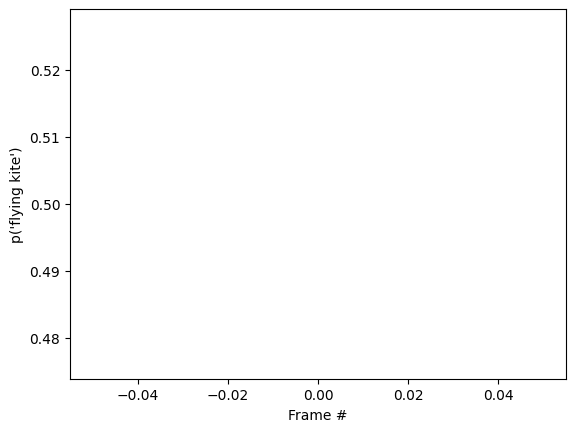

In [ ]:
id = tf.argmax(probabilities[-1])
plt.plot(probabilities[:, id])
plt.xlabel('Frame #')
plt.ylabel(f"p('{KINETICS_600_LABELS[id]}')");

In [ ]:
for label, p in get_top_k(tf.reduce_mean(probabilities, axis=0)):
  print(f'{label:20s}: {p:.3f}')

golf chipping       : 0.358
mowing lawn         : 0.128
slacklining         : 0.091
golf driving        : 0.090
golf putting        : 0.075


++++++++++++++++++++++==================

In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

photobombing        : 0.256
waving hand         : 0.233
sign language interpreting: 0.043
shaving head        : 0.041
stretching arm      : 0.025


photobombing        : 0.256
waving hand         : 0.233
sign language interpreting: 0.043
shaving head        : 0.041
stretching arm      : 0.025    #for frame size 20

In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

waving hand         : 0.279
photobombing        : 0.178
shaving head        : 0.045
cleaning windows    : 0.043
playing darts       : 0.023


In [ ]:
probs = tf.nn.softmax(logits, axis=-1)
for label, p in get_top_k(probs):
  print(f'{label:20s}: {p:.3f}')

waving hand         : 0.354
photobombing        : 0.283
shaving head        : 0.025
sign language interpreting: 0.020
stretching arm      : 0.018


waving hand         : 0.279
photobombing        : 0.178
shaving head        : 0.045
cleaning windows    : 0.043
playing darts       : 0.023   # for frame size 10